In [1]:
# Libraries
import gpflow
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import waveome

## Data Preparation

In [2]:
# Data Read
mbx = pd.read_csv('../iHMP/data/iHMP_labeled_metabolomics.csv', low_memory=False)
mtd = pd.read_csv('../iHMP/data/iHMP_metadata.csv', low_memory=False)

# Print out sizes

# Clean up
# Save separate lookup table
mbx_lookup = mbx[['HMDB (*Representative ID)', 'Metabolite', 'Compound']]
mbx = (
    mbx
    # Drop all column identifiers that aren't necessary for search
    .drop(columns=mbx.columns[:6])
    # Prepare to transpose dataframe
    .set_index('Compound')
    # Make sure we have observation (row) by metabolite (column)
    .transpose()
    # Pull off index for matching
    .reset_index(names='External ID')
    # Impute zero for missing intensity value
    .fillna(0.)
    .set_index('External ID')
    .sort_index()
)
mbx

Compound,C18n_QI06,C18n_QI07,C18n_QI08,C18n_QI09,C18n_QI10,C18n_QI11,C18n_TF1,C18n_QI12,C18n_QI13,C18n_QI14,...,HILp_QI13155,HILp_TF17,HILp_TF35,HILp_TF19,HILp_QI25304,HILp_TF2,HILp_TF3,HILp_TF12,HILp_QI23736,HILp_QI24373
External ID,,,,,,,,,,,,,,,,,,,,,
CSM5FZ3N,942546.0,1418451.0,2194.0,0.0,38180.0,5893.0,0.0,4174.0,211440.0,15667.0,...,19777461.0,9997928.0,3579319.0,2066660.0,86595.0,274385476.0,136360623.0,2.119068e+08,36328.0,586321.0
CSM5FZ3T,470132.0,416924.0,28.0,0.0,11781.0,6345.0,0.0,5257.0,29713.0,2833.0,...,34863534.0,69914375.0,6996249.0,15657037.0,1162223.0,70872089.0,5868952.0,3.456104e+09,119223.0,3284388.0
CSM5FZ44,720369.0,1198835.0,436.0,0.0,8721.0,14372.0,0.0,5462.0,86293.0,64553.0,...,15526303.0,12300553.0,1812524.0,7134468.0,95476.0,90077297.0,10050253.0,9.373580e+08,0.0,323194.0
CSM5FZ48,1069292.0,1256069.0,773.0,0.0,62098.0,5653.0,0.0,3628.0,9523.0,18466.0,...,14346185.0,14010937.0,4867731.0,17058734.0,0.0,250558333.0,238294493.0,3.669375e+08,36710.0,885943.0
CSM5FZ4A,1265301.0,1368667.0,542.0,0.0,3235743.0,10058.0,0.0,5165.0,25482.0,9282.0,...,32308733.0,11756268.0,4435431.0,5256579.0,80735.0,6695543.0,872027.0,5.998712e+08,13503.0,1555485.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PSMA26A3,380042.0,320397.0,1008.0,0.0,108669.0,11948.0,499437.0,3172.0,10599.0,12693.0,...,3250546.0,5144501.0,1554451.0,197869363.0,0.0,34836268.0,22973938.0,3.254163e+09,13148.0,2717657.0
PSMA26AJ,2930386.0,2661474.0,178.0,0.0,22508.0,4892.0,0.0,2441.0,42024.0,7902.0,...,7154808.0,9858268.0,0.0,11257588.0,2302.0,145032134.0,80538278.0,6.841049e+08,0.0,231075.0
PSMB4MBK,494213.0,634210.0,193.0,0.0,24374.0,4879.0,0.0,4165.0,198330.0,10425.0,...,10419020.0,8170396.0,931220.0,6057583.0,0.0,10612065.0,6931891.0,1.519354e+09,0.0,191390.0


In [3]:
mbx_lookup

,HMDB (*Representative ID),Metabolite,Compound
0,HMDB04705,12.13-diHOME,C18n_QI06
1,HMDB04704,9.10-diHOME,C18n_QI07
2,HMDB00535,caproate,C18n_QI08
3,HMDB00666,heptanoate,C18n_QI09
4,HMDB00764,hydrocinnamate,C18n_QI10
...,...,...,...
591,HMDB00252*,sphingosine-isomer1,HILp_TF2
592,HMDB00252*,sphingosine-isomer2,HILp_TF3
593,HMDB00252*,sphingosine-isomer3,HILp_TF12
594,HMDB12097,C14:0 SM,HILp_QI23736


In [4]:
pd.set_option('display.max_columns', 500)
'''
Metadata column selection:
- External ID (sample ID)
- Participant ID (person ID)
- date_of_receipt
- site_name (location)
- Age at diagnosis 
- consent_age
- diagnosis
- General wellbeing
- Abdominal pain
- Number of liquid or very soft stools in the past 24 hours:
- Arthralgia (joint pain)
- hbi
- Hispanic or Latino Origin
- BMI
- Height
- Weight.1
- Cancer columns
- Subject was diagnosed within the last 6 months
- Age at diagnosis (A)
- race
- Blood in the stool
- General well being over the past 24 hours
- sccai
- sex
- smoking status
'''

column_list = [
    'External ID', 'Participant ID', 'site_name', 'Age at diagnosis',
    'consent_age', 'diagnosis', 'General wellbeing', 
    'hbi', 'Hispanic or Latino Origin', #'BMI',
    'date_of_receipt', 'race', 
    'General well being over the past 24 hours', 'sccai', 'sex',
]

# Now prepare metadata set
mtd_sub = (
    mtd
    .loc[mtd['data_type'].values == 'metabolomics', column_list]
    .rename(columns={
        'Participant ID': 'participant_id',
        'Age at diagnosis': 'age_at_diagnosis',
        'Hispanic or Latino Origin': 'hispanic'
    })
    .assign(disease_years = lambda x: x['consent_age'] - x['age_at_diagnosis'])
    .assign(study_days = lambda x: (
        pd.to_datetime(x['date_of_receipt']) 
        - pd.to_datetime(x['date_of_receipt']).min()
        ).dt.days#.astype('timedelta64[D]')
    )
    .assign(age = lambda x: x['consent_age'] + (x['study_days']/365.))
    .assign(general_wellbeing = lambda x: x['General wellbeing'].combine_first(x['General well being over the past 24 hours']))
    .assign(severity = lambda x: np.where(x['diagnosis'] == 'CD', x['hbi'], x['sccai']))
    .assign(active_disease = lambda x: np.where(x['severity'] >= 5, '1', '0'))
    .assign()
    # .groupby('participant_id', as_index=False)
    # .assign(max_disease_date = lambda x: np.where(x['severity'] == x['severity'].max(), x['date_of_receipt'], np.nan))
    .drop(columns=[
        'General wellbeing', 'General well being over the past 24 hours',
        'hbi', 'sccai',
        'date_of_receipt'
    ])
    .set_index('External ID')
    .sort_index()
)
mtd_sub

,participant_id,site_name,age_at_diagnosis,consent_age,diagnosis,hispanic,race,sex,disease_years,study_days,age,general_wellbeing,severity,active_disease
External ID,,,,,,,,,,,,,,
CSM5FZ3N,C3001,Cedars-Sinai,28.0,43.0,CD,Not Hispanic or Latino,White,Female,15.0,93,43.254795,Slightly below par,4.0,0
CSM5FZ3T,C3002,Cedars-Sinai,47.0,76.0,CD,Not Hispanic or Latino,White,Female,29.0,139,76.380822,Poor,9.0,1
CSM5FZ44,C3002,Cedars-Sinai,47.0,76.0,CD,Not Hispanic or Latino,White,Female,29.0,195,76.534247,Slightly below par,7.0,1
CSM5FZ48,C3003,Cedars-Sinai,29.0,43.0,UC,Not Hispanic or Latino,White,Female,14.0,148,43.405479,Very well,2.0,0
CSM5FZ4A,C3004,Cedars-Sinai,33.0,47.0,UC,Not Hispanic or Latino,White,Female,14.0,153,47.419178,Very well,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PSMA26A3,P6038,MGH Pediatrics,8.0,16.0,UC,Not Hispanic or Latino,White,Female,8.0,883,18.419178,Slightly below par,2.0,0
PSMA26AJ,P6033,MGH Pediatrics,15.0,15.0,CD,Not Hispanic or Latino,White,Male,0.0,867,17.375342,Very Well,1.0,0
PSMB4MBK,P6035,MGH Pediatrics,16.0,16.0,UC,Not Hispanic or Latino,White,Male,0.0,903,18.473973,Very well,2.0,0


## Model Search

In [5]:
# Performed on HPC cluster!
with open("./output/ihmp_waveome_output.pickle", "rb") as f:
    gps = pickle.load(f)

In [6]:
# How many metabolites have we analyzed?
print(f"Number of metabolites analyzed: {len(gps.models)}")

Number of metabolites analyzed: 596


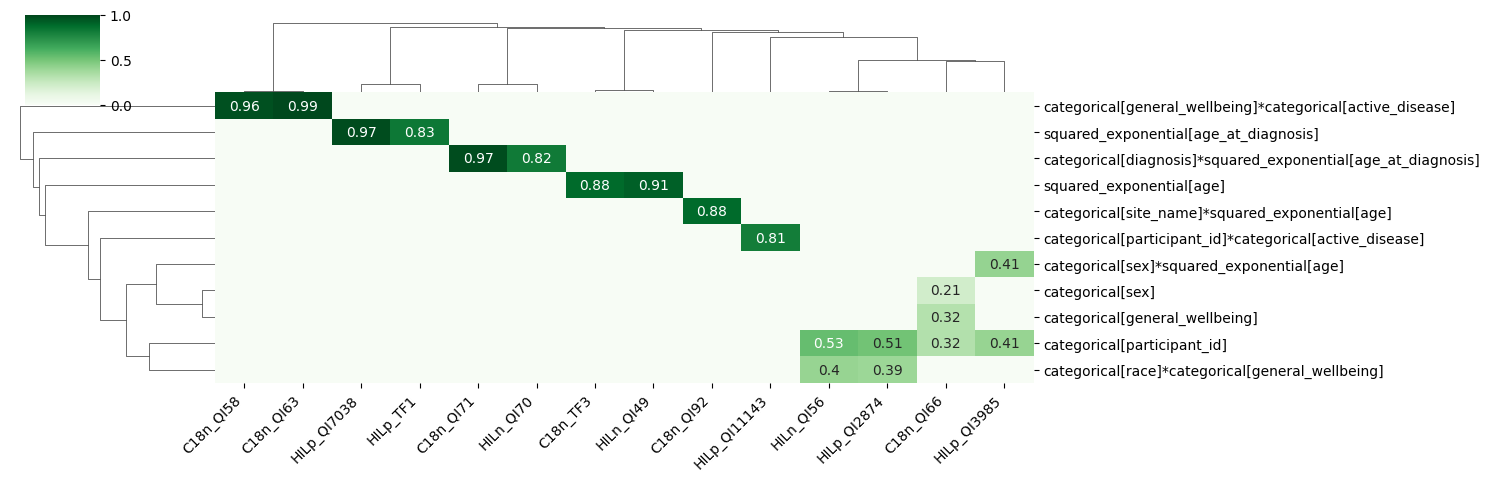

In [7]:
# Look at overall heatmap
gps.plot_heatmap()

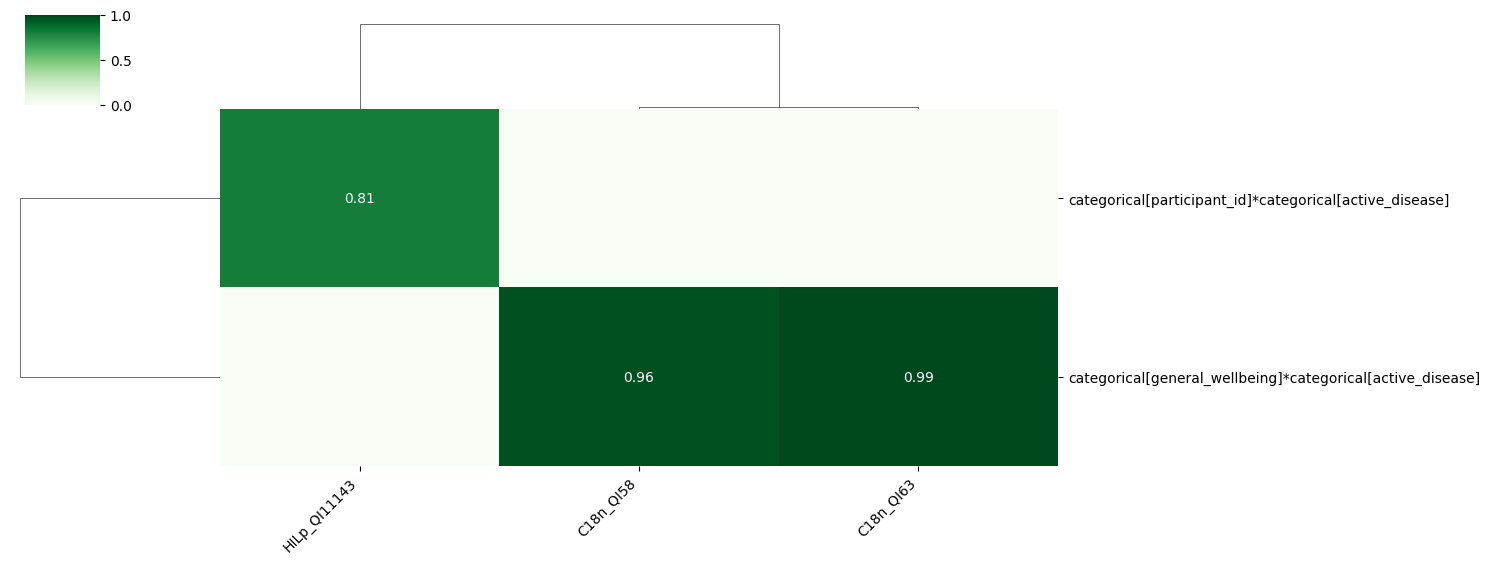

In [8]:
# Look at heatmap for specific feature of interest
gps.plot_heatmap(feat="active_disease")

In [9]:
# Look up compound name
compound_tag = "C18n_QI63"
mbx_lookup.query(f"Compound == '{compound_tag}'")

,HMDB (*Representative ID),Metabolite,Compound
60,HMDB00874*,taurohyodeoxycholate/tauroursodeoxycholate,C18n_QI63


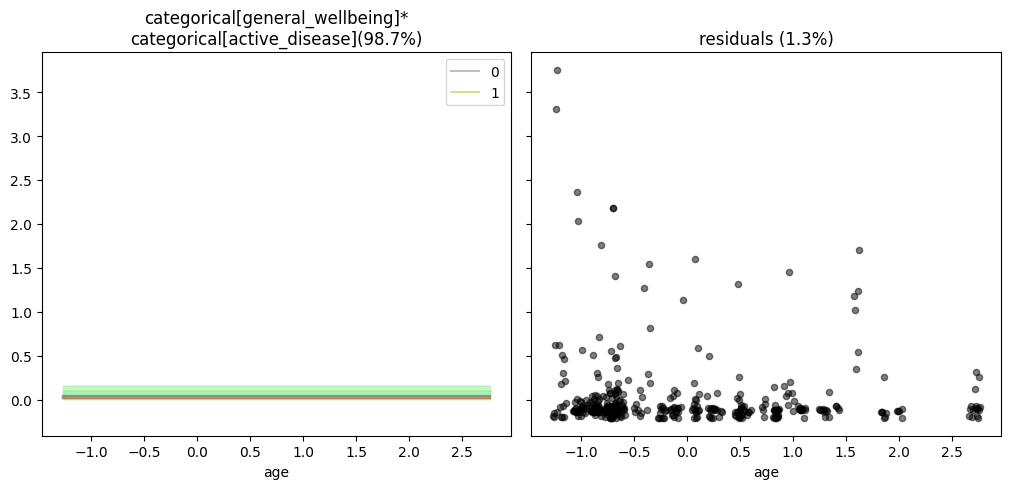

In [10]:
gps.plot_parts(out_label=compound_tag, x_axis_label="age")
plt.show()

In [11]:
# Look at the pre-made crosswalk between individual ID and new float value
gps.categorical_dict["participant_id"]

(array([ 0,  1,  1,  2,  3,  0,  2,  4,  5,  6,  3,  5,  4,  7,  1,  0,  6,
         7,  8,  5,  9, 10,  3,  8,  4,  2,  9, 11,  6, 10, 11, 12, 13, 14,
         0,  7, 12, 13, 14,  1,  1,  2,  8,  3,  4,  4,  9,  9,  5, 10, 15,
        11,  0, 15, 16,  7,  7, 12, 13, 14, 17, 18, 19, 20, 20,  1,  8,  6,
        17,  3,  2,  5,  0, 16, 10, 15, 11, 21, 22, 23, 20,  7, 13, 14, 17,
         8,  8, 16, 18, 19,  9, 10, 10, 15, 15, 15, 11, 20, 21, 21, 21, 12,
        12, 13, 13, 13, 24, 14, 14, 17, 23, 19, 16, 15, 22, 21, 21, 24, 24,
        23, 18, 22, 24, 24, 17, 23, 23, 21, 21, 24, 22, 22, 24, 24, 20, 20,
        25, 26, 27, 27, 25, 25, 27, 27, 27, 25, 25, 26, 26, 26, 26, 28, 28,
        29, 30, 30, 30, 31, 32, 32, 33, 33, 33, 28, 33, 34, 29, 34, 28, 28,
        28, 31, 28, 32, 31, 30, 35, 35, 28, 31, 30, 35, 32, 36, 37, 36, 37,
        29, 34, 33, 32, 30, 30, 37, 29, 29, 31, 31, 36, 36, 34, 33, 33, 38,
        39, 40, 38, 41, 41, 42, 35, 43, 43, 44, 45, 41, 41, 46, 37, 37, 40,
        42, 

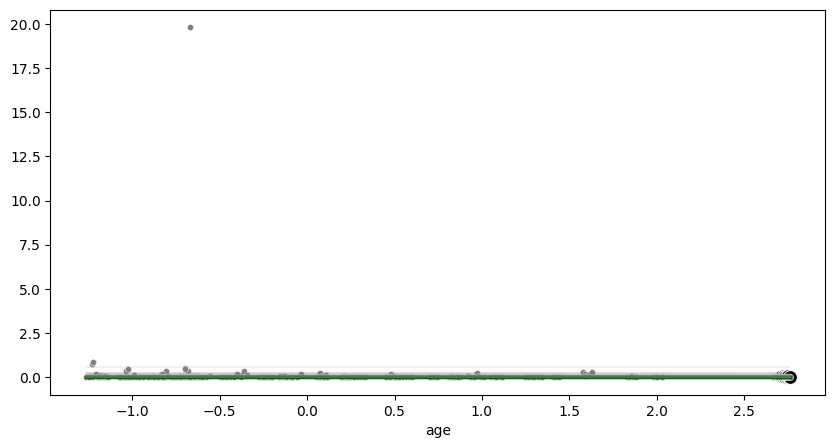

In [12]:
# Plot the GP for a given unit/individual id
gps.plot_marginal(
    out_label=compound_tag,
    x_axis_label="age",
    unit_label=1 # This corresponds to participant_id = "C3002"
)
plt.show()

Let's look at another metabolite that has a large amount of variance explained by the model/kernel components.

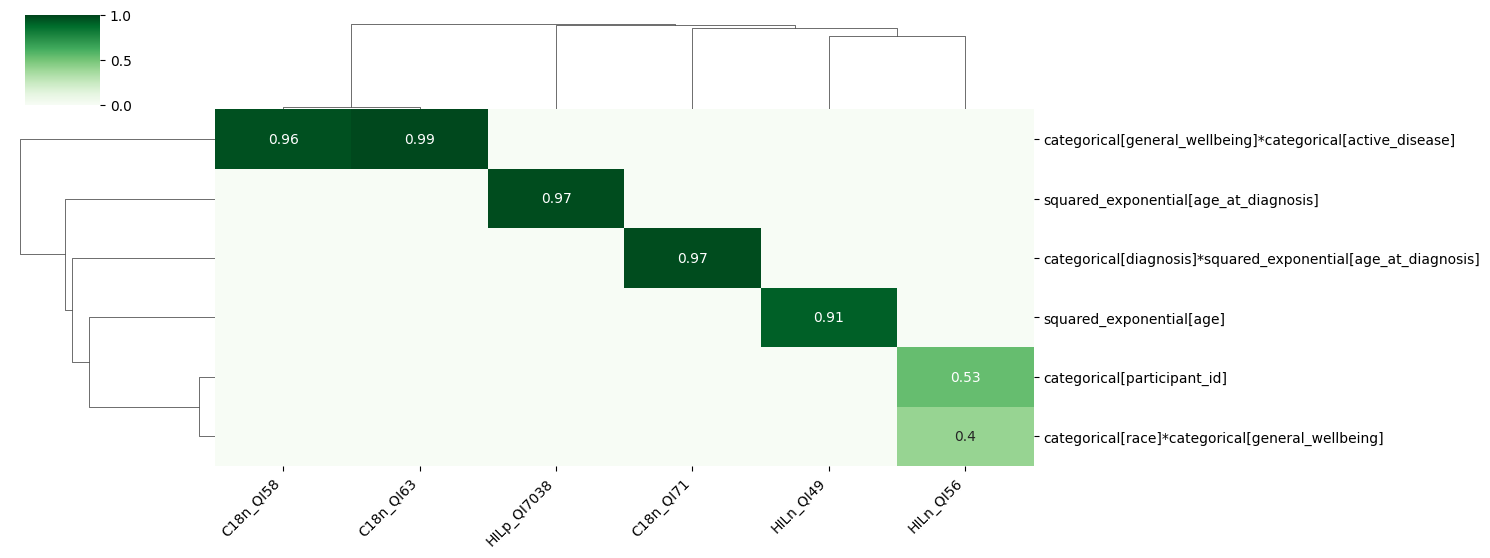

In [13]:
# Look at heatmap for most explainable metabolite
gps.plot_heatmap(var_cutoff=0.90)

   HMDB (*Representative ID)           Metabolite   Compound
70                 HMDB01928  hydrochlorothiazide  C18n_QI71


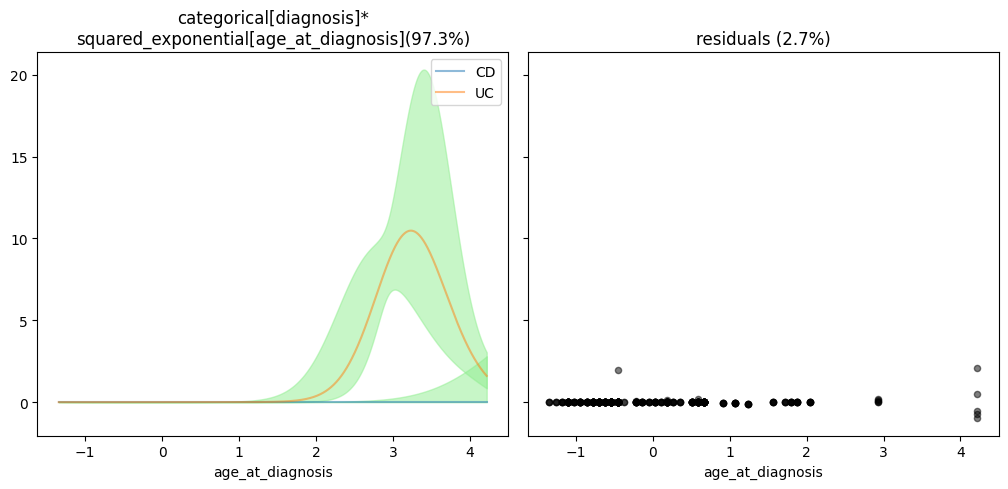

In [14]:
# Let's look at the metabolite that seems to be associated with diagnosis x age at diagnosis
compound_tag2 = "C18n_QI71"
print(mbx_lookup.query(f"Compound == '{compound_tag2}'"))
gps.plot_parts(
    out_label=compound_tag2,
    x_axis_label="age_at_diagnosis"
)
plt.show()

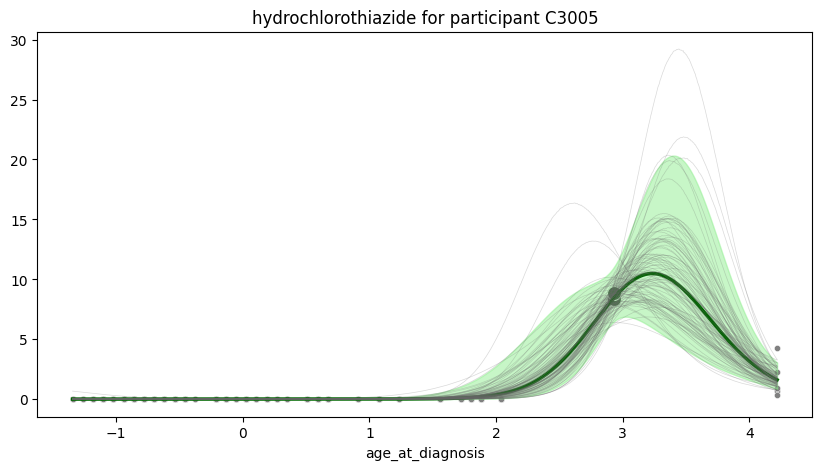

In [15]:
# Plot the GP for a given unit/individual id
unit_index = 4
gps.plot_marginal(
    out_label=compound_tag2,
    x_axis_label="age_at_diagnosis",
    unit_label=unit_index
)
plt.title(
    mbx_lookup.query(f"Compound == '{compound_tag2}'")["Metabolite"].values[0]
    + f" for participant {gps.categorical_dict['participant_id'][1][unit_index]}"
)
plt.show()